# Extinction Law

**@juliaroquette (20 Dec 23):** I think there is a bug in terms of wl and x being mixed in the final code

**@juliaroquette (08 Dec 23):**

This note include some steps towards implementing a python code to generate extinction curves. Shortly after I started developing it back in November, `astropy` released a `dust_extinction` package which includes the same sort of python code I was developing here. Hence after a few steps I developed before, I decided to change the focus to implement my use of `dust_extinction` instead. 

**Context:** We are interested in looking at SEDs containing data observed in the wavelength range 0.1--1000$\mu$m. 

This interval was thought to include dust observation at the 1nm scale as well as the FUV band from GALEX (which I think is the most UV observation we can get on a big data level). For the extremes of this range we have to rely on Grain models for the extinction curve. #Conclusion section below describe the final assumptions and extinction curve chosen.

**@juliaroquette (14 Nov 23):** A few steps towards implementing extinction laws for SEDan+.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
wl = np.logspace(start=-1, stop=3, num=1000, base=10)

## Cardelli 89

Following [Cardelli et al. 1989 ApJ 345 245](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract 
), here I am implementing a parametrization for the extinction law for the Galaxy.

\begin{equation}
\Bigg< \frac{A_\lambda}{A_V}\Bigg>=a\Big(\frac{1}{\lambda}\Big)+\frac{b\Big(\frac{1}{\lambda}\Big)}{R_V}
\end{equation}

The definitions of $a\Big(\frac{1}{\lambda}\Big)$ and $b\Big(\frac{1}{\lambda}\Big)$ are divided into four wavelength ranges:

- FUV: $8\mu m^{-1}\leq\frac{1}{\lambda}\leq10\mu m^{-1}$ ($\sim 0.1-0.125 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big)=-1.073-0.628\Big(\frac{1}{\lambda}-8\Big)+0.137\Big(\frac{1}{\lambda}-8\Big)^2-0.070\Big(\frac{1}{\lambda}-8\Big)^2$
    
    $b\Big(\frac{1}{\lambda}\Big)=13.670+4.257\Big(\frac{1}{\lambda}-8\Big)-0.420\Big(\frac{1}{\lambda}-8\Big)^2+0.374\Big(\frac{1}{\lambda}-8\Big)^3$ 
    
- UV: $3.3\mu m^{-1}\leq\frac{1}{\lambda}\leq8\mu m^{-1}$ ($\sim 0.125-0.91 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big) =  1.752 - 0.316\Big(\frac{1}{\lambda}\Big) - \frac{0.104}{\Bigg[\Big(\frac{1}{\lambda} - 4.67\Big)^2 + 0.341\Bigg]} + F_a\Big(\frac{1}{\lambda}\Big)$, and
    
    $b\Big(\frac{1}{\lambda}\Big) = -3.090 + 1.825\Big(\frac{1}{\lambda}\Big) + \frac{1.206}{\Bigg[\Big(\frac{1}{\lambda} - 4.62\Big)^2 + 0.263\Bigg]} + F_b\Big(\frac{1}{\lambda}\Big)$, where:
    
    $F_a\Big(\frac{1}{\lambda}\Big) = - 0.04473(\frac{1}{\lambda} - 5.9)^2 - 0.009779(\frac{1}{\lambda} - 5.9)^3 $ for $8\geq\frac{1}{\lambda}\geq 5.9$
    
    $F_b\Big(\frac{1}{\lambda}\Big) = 0.2130(\frac{1}{\lambda} - 5.9)^2 + 0.1207(\frac{1}{\lambda} - 5.9)^3 $ for $8\geq\frac{1}{\lambda}\geq 5.9$
       
    $F_a\Big(\frac{1}{\lambda}\Big) = F_b\Big(\frac{1}{\lambda}\Big) = 0 $ for $\frac{1}{\lambda}< 5.9$

- Optical/near-infrared: $1.1\mu m^{-1}\leq\frac{1}{\lambda}\leq3.3\mu m^{-1}$ ($\sim 0.3-0.91 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big) = 1 + 0.17699y - 0.50447y^2 - 0.02427y^3 + 0.72085y^4 + 0.01979y^5 - 0.77530y^6 + 0.32999y^7$, where $y = \frac{1}{\lambda}-1.82$
    
    $b\Big(\frac{1}{\lambda}\Big) = 1.41338y + 2.28305y^2 + 1.07233y^3 - 5.38434y^4 - 0.62251y^5 + 5.30260y^6 - 2.09002y^7$ 
    
- Infrared: $0.3\mu m^{-1}\leq\frac{1}{\lambda}\leq1.1\mu m^{-1}$ ($\sim 0.91-3.3 \mu m$)


    $a\Big(\frac{1}{\lambda}\Big)=0.574\times\Big(\frac{1}{\lambda}\Big)^{1.61}$ 
    
    $b\Big(\frac{1}{\lambda}\Big)=-0.527\times\Big(\frac{1}{\lambda}\Big)^{1.61}$ 
    


In [3]:
def cardeli89_Awl_Av(x, Rv=3.1):
    """
    input:
    1/wavelength
    - wavelength in microm
    """
    x = np.atleast_1d(x)
   # x = 1./np.array(wavelength)
    def ax(x):
        
        # IR
        ir = (x >= 0.3) & (x <= 1.1)  & (x > 0)
        ir_result = np.where(ir, 0.574 * (x**1.61), 0)

        # OIR
        y = x - 1.82
        oir = (x > 1.1) & (x < 3.3)
        oir_result = np.where(oir, 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4\
                           + 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7, 0) 

        # UV
        uv = (x >= 3.3) & (x <= 8.) & (x > 0)
        def Fa(x):
            fa_condition = (x < 5.9) & (x > 0)
            return np.where(fa_condition, 0, -0.04473*(x - 5.9)**2 - 0.009779*(x - 5.9)**3)
        uv_result = np.where(uv, 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341) + Fa(x), 0)

        # FUV
        fuv = (x > 8) & (x <= 10.) & (x > 0)
        fuv_result = np.where(fuv, -1.073 - 0.628*(x - 8.) + 0.137*(x - 8.)**2 - 0.070*(x - 8.)**3 , 0)


        # Outside range
        outside = ~ir & ~oir & ~uv & ~fuv
        outside_result = np.where(outside, np.nan, 0.)

        return  ir_result + oir_result + uv_result + fuv_result + outside_result
    def bx(x):
        # IR
        ir = (x >= 0.3) & (x <= 1.1) & (x > 0)
        ir_result = np.where(ir, -0.527*(x**1.61), 0)

        # OIR
        oir = (x > 1.1) & (x < 3.3) & (x > 0)
        y = x - 1.82
        oir_result = np.where(oir, 1.41338*y + 2.28305*y**2 +
                              1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 +
                              5.30260*y**6 - 2.09002*y**7 , 0)

        # UV
        uv = (x >= 3.3) & (x <= 8.) & (x > 0)
        def Fb(x):
            fb_condition = (x < 5.9) & (x > 0)
            return np.where(fb_condition, 0,  0.2130*(x - 5.9)**2 + 0.1207*(x - 5.9)**3)
        uv_result = np.where(uv,  -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)+ Fb(x), 0)
        
        # FUV
        fuv = (x > 8.) & (x <= 10.) & (x > 0)
        fuv_result = np.where(fuv, 13.670 + 4.257*(x - 8) - 0.420*(x - 8)**2 + 0.374*(x - 8)**3, 0)
        

        # Outside range
        outside = ~ir & ~oir & ~uv & ~fuv
        outside_result = np.where(outside, np.nan, 0)

        return ir_result + oir_result + uv_result + fuv_result + outside_result
    return ax(x) + bx(x)/Rv

Based on Table 3 from Cardelli+89, this tests if my implementation is correct:

Text(0, 0.5, '$\\frac{A_\\lambda}{A_V}$')

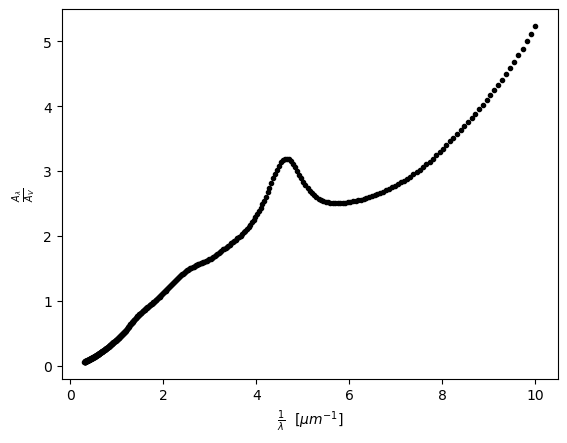

In [4]:
plt.plot(1/wl, cardeli89_Awl_Av(1/wl), 'k.')
plt.xlabel(r'$\frac{1}{\lambda}$  $[\mu m^{-1}]$')
# plt.axvline(8)
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')

Text(0.5, 0, '$\\lambda$  $[\\mu m]$')

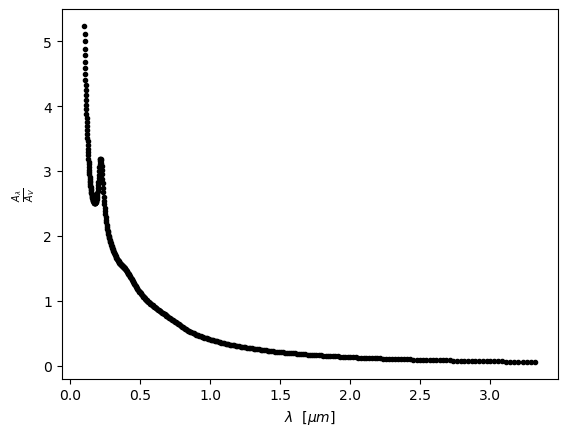

In [5]:
plt.plot(wl, cardeli89_Awl_Av(1/wl), 'k.')
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')
plt.xlabel(r'$\lambda$  $[\mu m]$')


# Indebetouw et al. 2005

Following [Indebetouw et al. 2005 ApJ, 619, 931](https://ui.adsabs.harvard.edu/abs/2005ApJ...619..931I/abstract) here I am implemented another extinction law that covers the wavelength range $1.25 \mu m \leq \lambda \leq 8.0 \mu m$, which was derived based on GLIMPSE data (IRAC bands) + 2MASS. This will extend the Cardelli curve down to redder wavelengths.

They look at the average extinction in a few different fields in the Galaxy and provide as well an average value. With their equation (4), they provide a simple fit to the average value.

$$\log \Bigg(\frac{A_\lambda}{A_K}\Bigg) = (0.61\pm0.04) - (2.22\pm0.17) \log(\lambda) + (1.21\pm0.23) \Bigg[\log(\lambda)\Bigg]^2$$


In [6]:
lambda_K = 2.164 #mum
AK_AV = cardeli89_Awl_Av(1./lambda_K)
print("A_K/A_V={0}".format(AK_AV))

A_K/A_V=[0.11657816]


In [7]:
def indebetouw2005(wl, AV=True):
    x = np.atleast_1d(wl)
    wl_range = (x >= 1.25) & (x <= 8.)
    A_wl_A_K = np.where(wl_range, 10**(0.61 - 2.22*np.log10(x) + 1.21*(np.log10(x))**2), np.nan)

    # Check if AV is True
    if not bool(AV):
        return A_wl_A_K
    else:
        # Assuming lambda_K is defined somewhere
        return A_wl_A_K * cardeli89_Awl_Av(1./lambda_K)

Text(0, 0.5, '$\\frac{A_\\lambda}{A_V}$')

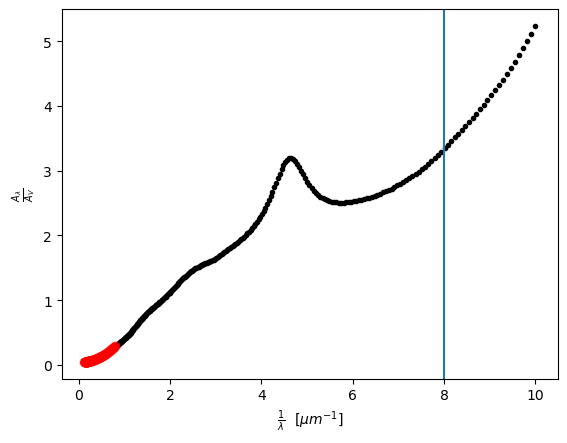

In [8]:
plt.plot(1/wl, cardeli89_Awl_Av(1/wl), 'k.')
plt.plot(1/wl, indebetouw2005(wl), 'ro',  alpha=0.3)

plt.axvline(8)
plt.xlabel(r'$\frac{1}{\lambda}$  $[\mu m^{-1}]$')
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')

Text(0, 0.5, '$\\frac{A_\\lambda}{A_V}$')

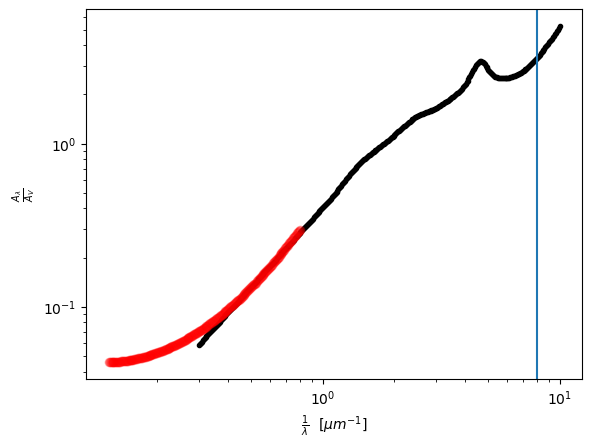

In [9]:
plt.loglog(1/wl, cardeli89_Awl_Av(1/wl), 'k.')
plt.loglog(1/wl, indebetouw2005(wl), 'ro',  alpha=0.3)

plt.axvline(8)
plt.xlabel(r'$\frac{1}{\lambda}$  $[\mu m^{-1}]$')
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')

## extinction for the far-IR and submm

A lot of modern studies present a miss-citted extinction law for the far-IR and submm. They refer to is as from Cardeli+89, but Marc figured out this is because the review by [Mathis 1990 Review](https://ui.adsabs.harvard.edu/abs/1990ARA%26A..28...37M/abstract) presents this in the same table as the Cardeli values. By digging in the review, these values seem to have been estimated by Mathis himself based on grain models available at the time. These are given in $A_J$, hence need to be transformed to $A_V$.

In [10]:
def mathis90(wl, AV=False):
    wl = np.atleast_1d(wl)
    wl_J = 1.25 #micron
    wl_ = np.array([1.25, 1.65, 2.2, 3.4, 5., 7., 9., 9.7, 10., 12., 15., 18., 20., 25., 35., 60., 100., 250.])
    AlAJ = np.array([1., 0.624, 0.382, 0.182, 0.095, 0.07, 0.157, 0.208, 0.192, 0.098, 0.053, 0.083 , 0.075 , 0.048 , 0.013 , 0.0071, 0.0041, 0.0015])
    A_wl_A_J = np.full(len(wl), np.nan)
    mask = (wl >= 1.25) & (wl <= 250)
    A_wl_A_J[mask] = 10**np.interp(np.log10(wl[mask]), np.log10(wl_), np.log10(AlAJ))

    # Check if AV is True
    if not bool(AV):
        return A_wl_A_J
    else:
        # Assuming lambda_K is defined somewhere
        return A_wl_A_J * cardeli89_Awl_Av(1./wl_J)

Text(0, 0.5, '$\\frac{A_\\lambda}{A_J}$')

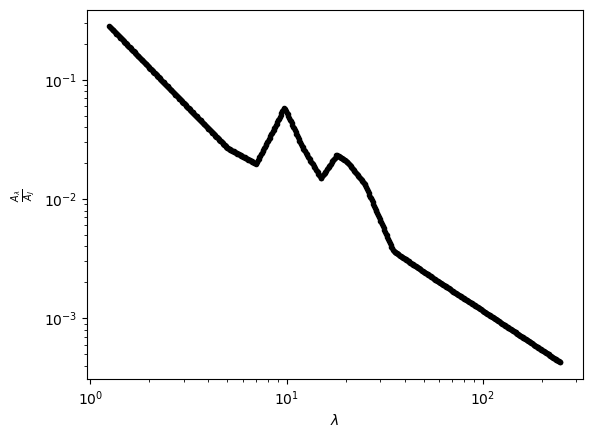

In [11]:
plt.loglog(wl, mathis90(wl, AV=True), 'k.')
plt.xlabel('$\lambda$')
plt.ylabel(r'$\frac{A_\lambda}{A_J}$')

## Gordon et al. 2023

A very recent paper by [Gordon et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...950...86G/abstract) has self-conistently derived extinction derived extinction curves for the range 912$\AA$ to 32 $\mu$m and for $R_V$ in the range 2.3-5.6. For that, they employed 4 previous samples of spectroscopic observations by 
Gordon et al. (2009), Fitzpatrick et al. (2019),  Gordon et al. (2021) and Decleir et al. (2022). They use the traditional method to parametrise extinction (same as Cardelli+89) where:

$\frac{A_\lambda}{A_V} = a(\lambda)+b(\lambda)\big[\frac{1}{R_V}-\frac{1}{3.1}\big]$,

they also define a covariance relation in order to account for the different uncertainties involved and they use a fitting technique called 2DCORR.

Their results have been released a few weeks ago as part of `astropy`'s new package [`dust_extinction`](https://dust-extinction.readthedocs.io/en/stable/index.html).

This also includes the extinction laws I implemented this last month (duh). [This page](https://dust-extinction.readthedocs.io/en/stable/dust_extinction/choose_model.html) list all the models available and some of their properties. 

Note that the Gordon+2023 model itself won't cover the whole range of interest for us. Hence an alternative is to use one of the Grain Models extinction law available on the `dust_extinction` package. 



In [12]:
from dust_extinction.parameter_averages import G23

In [13]:
def ext_G23(x, Rv=3.1):
    assert (Rv >= 2.3) & (Rv <= 5.6), 'Rv should be in the range 2.3-5.6'
    x = np.atleast_1d(x)
    mask = (x > 0.03125) & (x < 10.96) 
    ext = G23(Rv=Rv)
    Av = np.full(len(x), np.nan)
    Av[mask] = ext(x[mask])
    return Av


/Users/juliaroquette/anaconda3/envs/NEMESIS/lib/python3.10/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


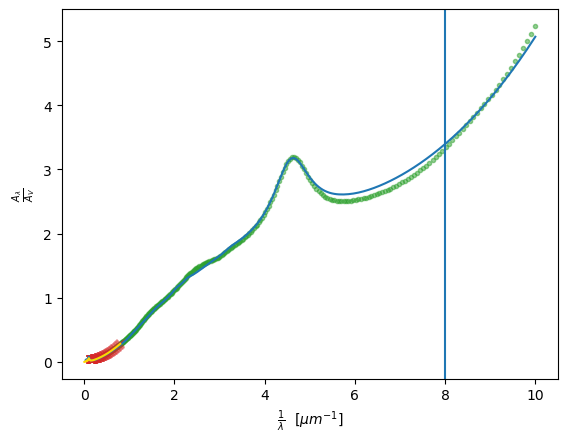

In [14]:
plt.plot(1./wl, cardeli89_Awl_Av(1/wl), '.', color="tab:green", alpha=0.5, label='Cardeli+89')
plt.plot(1./wl, indebetouw2005(wl), 'x', color="tab:red",  alpha=0.3, label='Indebetouw+2005',)
plt.plot(1./wl, ext_G23(1/wl), label='Gordon+23', color="tab:blue")
plt.plot(1./wl, mathis90(wl, AV=True), 'gold', label="Mathis90")

plt.axvline(8)
plt.xlabel(r'$\frac{1}{\lambda}$  $[\mu m^{-1}]$')
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')
plt.savefig('/Users/juliaroquette/Work/Plots/Av_1_lambda.png')

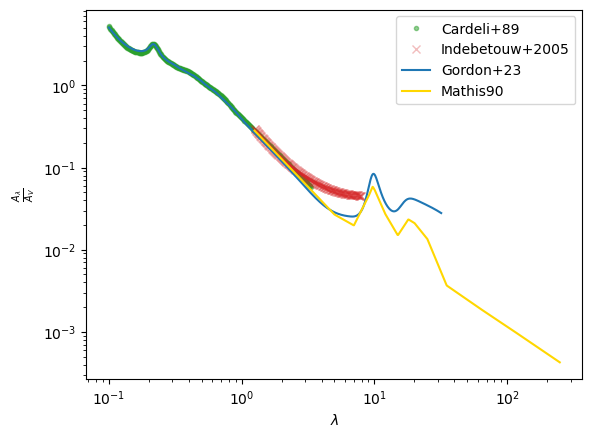

In [15]:
plt.plot(wl, cardeli89_Awl_Av(1/wl), '.', color="tab:green", alpha=0.5, label='Cardeli+89')
plt.plot(wl, indebetouw2005(wl), 'x', color="tab:red",  alpha=0.3, label='Indebetouw+2005',)
plt.plot(wl, ext_G23(1/wl), label='Gordon+23', color="tab:blue")
plt.plot(wl, mathis90(wl, AV=True), 'gold', label="Mathis90")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{A_\lambda}{A_V}$')
plt.legend()
plt.savefig('/Users/juliaroquette/Work/Plots/Av_lambda.png')

## Grain Models

The final question here is which grain model to use. From the documentation of `dust_extinction` it was pretty straightforward to get the code for a plot comparing the available models on top of which I can plot the extinction laws I have been looking at. To be consistent, I am only keeping the models for $R_V=3.1$ and for the Milky Way.

**Note on my choice**: I eliminated `DBP90` as this diverged a lot from the other at the longer wavelength range. `J13` seems to underestimate the silicate feature compared to the rest of the models, while `HD23` overestimate. `ZDA04` overestimates the UV bump. Among the remaining, I decided to choose the `D03` because it also provides models for $R_V=4.0$ and $R_V=5.5$. Thus if we want to test other $R_V$s in the future, this choice will make things easier. `WD01` would also provide this $R_V$ scalability, however `D03` covers a wider range of wavelengths. 



In [16]:
from dust_extinction.grain_models import DBP90, WD01, D03, ZDA04, C11, J13, HD23
models = [DBP90,
          WD01,
          D03,
          ZDA04,
          C11,
          J13,
          HD23
          ]
modelnames = ["MWRV31",
              "MWRV31",
              "MWRV31",
             "BARE-GR-S",
              "MWRV31",
              "MWRV31",
              "MWRV31"
              ]

for cmodel, cname in zip(models, modelnames):
   ext_model = cmodel(cname)
   print(cmodel, cname, ext_model.x_range)

<class 'dust_extinction.grain_models.DBP90'>
Name: DBP90 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [1e-05, 10.893246187363834]
<class 'dust_extinction.grain_models.WD01'>
Name: WD01 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [0.0001, 100.0]
<class 'dust_extinction.grain_models.D03'>
Name: D03 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [0.0001, 10000.0]
<class 'dust_extinction.grain_models.ZDA04'>
Name: ZDA04 (GMBase)
N_inputs: 1
N_outputs: 1 BARE-GR-S [0.0001, 1000.0]
<class 'dust_extinction.grain_models.C11'>
Name: C11 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [1e-05, 25.0]
<class 'dust_extinction.grain_models.J13'>
Name: J13 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [1e-05, 25.0]
<class 'dust_extinction.grain_models.HD23'>
Name: HD23 (GMBase)
N_inputs: 1
N_outputs: 1 MWRV31 [3.3333333333333335e-05, 10.0]


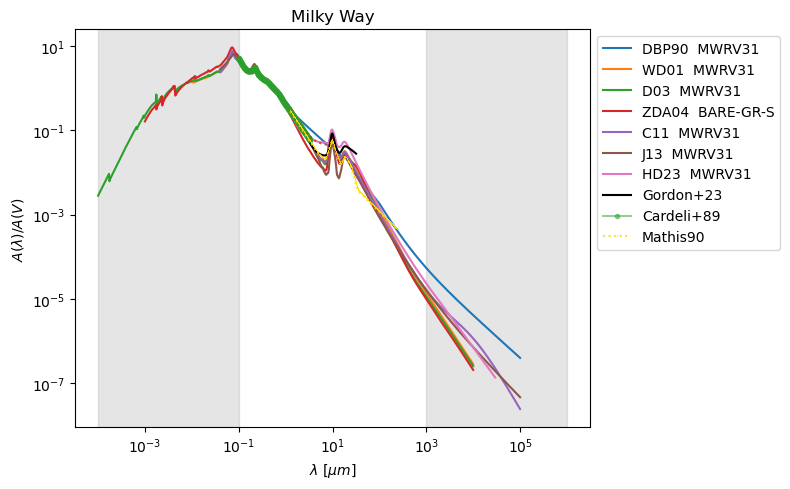

In [17]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(8, 5))

for cmodel, cname in zip(models, modelnames):
   ext_model = cmodel(cname)

   indxs, = np.where(np.logical_and(
      1./ lam >= ext_model.x_range[0],
      1./ lam <= ext_model.x_range[1]))
   yvals = ext_model(1/lam[indxs])
   ax.plot(lam[indxs], yvals, label=f"{ext_model.__class__.__name__}  {cname}")

ax.plot(wl, ext_G23(1/wl), label='Gordon+23', color="k")
plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)


plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Grain Models')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Milky Way')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


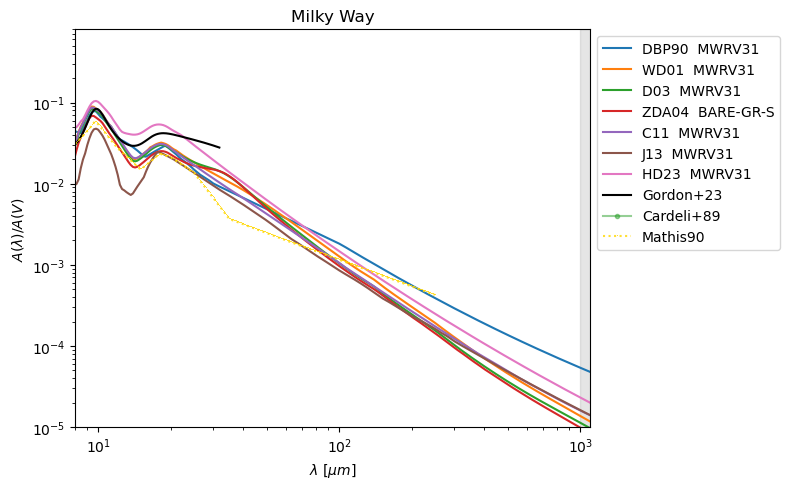

In [18]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(8, 5))

for cmodel, cname in zip(models, modelnames):
   ext_model = cmodel(cname)

   indxs, = np.where(np.logical_and(
      1./ lam >= ext_model.x_range[0],
      1./ lam <= ext_model.x_range[1]))
   yvals = ext_model(1./lam[indxs])
   ax.plot(lam[indxs], yvals, label=f"{ext_model.__class__.__name__}  {cname}")


ax.plot(wl, ext_G23(1/wl), label='Gordon+23', color="k")
plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)


plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Grain Models')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Milky Way')
ax.set_xlim(8, 1100)
ax.set_ylim(1e-5, 8e-1)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


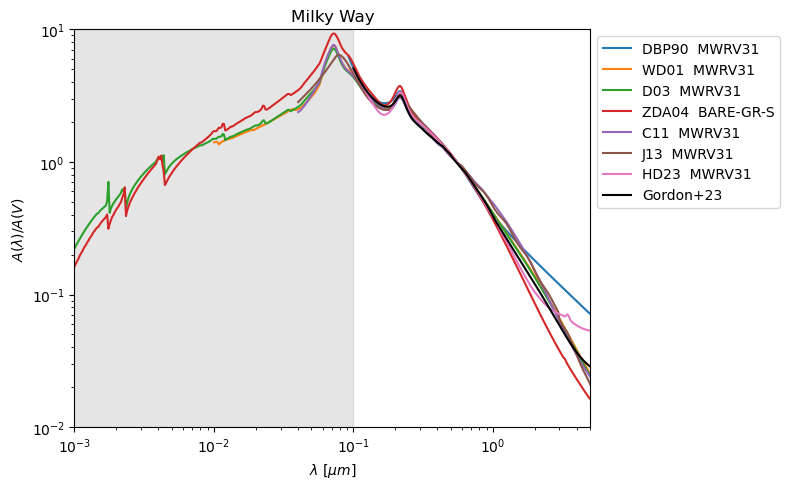

In [19]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(8, 5))


for cmodel, cname in zip(models, modelnames):
   ext_model = cmodel(cname)

   indxs, = np.where(np.logical_and(
      1./ lam >= ext_model.x_range[0],
      1./ lam <= ext_model.x_range[1]))
   yvals = ext_model(1./lam[indxs])
   ax.plot(lam[indxs], yvals, label=f"{ext_model.__class__.__name__}  {cname}")

ax.plot(wl, ext_G23(1/wl), label='Gordon+23', color="k")
# plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
# plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
# plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)


plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Grain Models')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Milky Way')
ax.set_xlim(.001, 5)
ax.set_ylim(1e-2, 1e1)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


**Note on wavelength truncation**: I decided to truncate the `G23` model at 12$\mu$m as I notice that it diverges from the `D03` model for longer wavelengths from that. At the other end, the same justification is used to truncate the `G23` model at 0.2$\mu$m

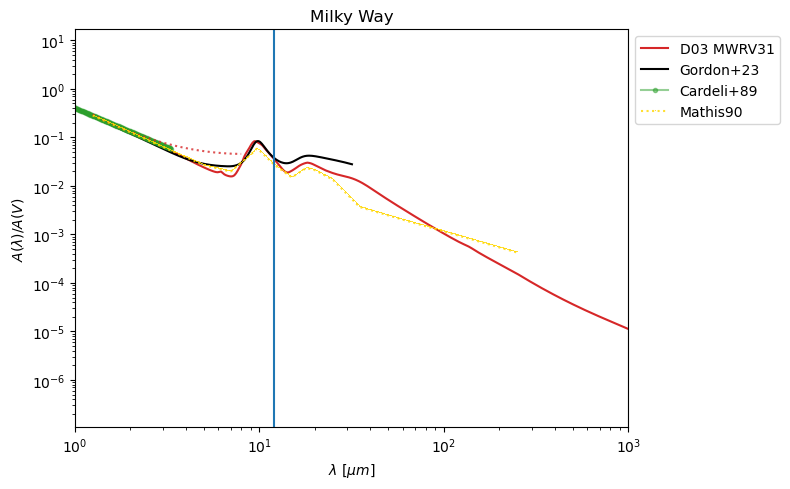

In [20]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(8, 5))
   
indxs, = np.where(np.logical_and(
      1./ lam >= D03.x_range[0],
      1./ lam <= D03.x_range[1]))
ax.plot(lam[indxs], D03("MWRV31")(1./lam[indxs]), label='D03 MWRV31', color="tab:red")

ax.plot(wl, ext_G23(1/wl), label='Gordon+23', color="k")
plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)



plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Grain Models')

ax.set_xscale('log')
ax.set_yscale('log')

ax.axvline(12)

ax.set_title('Milky Way')
ax.set_xlim(1, wl.max())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


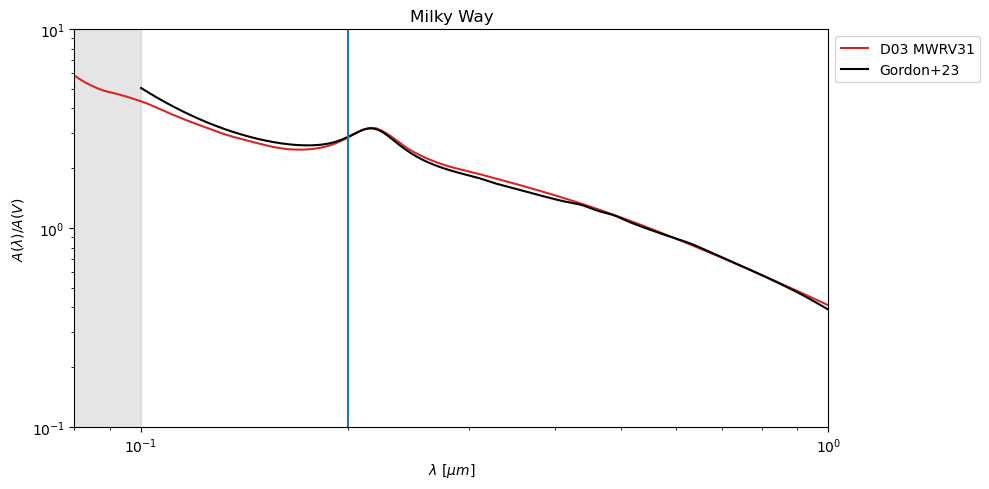

In [21]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(10, 5))
   
indxs, = np.where(np.logical_and(
      1./ lam >= D03.x_range[0],
      1./ lam <= D03.x_range[1]))
ax.plot(lam[indxs], D03("MWRV31")(1./lam[indxs]), label='D03 MWRV31', color="tab:red")

ax.plot(wl, ext_G23(1/wl), label='Gordon+23', color="k")
# plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
# plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
# plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)



plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Grain Models')

ax.set_xscale('log')
ax.set_yscale('log')

ax.axvline(0.2)
ax.set_xlim(.08, 1)
ax.set_ylim(1e-1,10)

ax.set_title('Milky Way')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [22]:
D03.x_range

[0.0001, 10000.0]

# Conclusion:


I have composed an extinction law (parametrised as $\frac{A_\lambda}{A_V}$) that covers wavelengths from 0.0001 -- 10000$\mu$m. Thanks to the recent release of the [`dust_extinction`](https://dust-extinction.readthedocs.io/en/stable/index.html) package as part of `astropy`, I could simplify the combinations of different extinction laws and dust grain models to build a single smooth curve that covers the whole range of interest. 

My Frankenstein extinction curve relies on the following assumptions:
1. $R_V=3.1$ - although in the future I may want to escalate this for other values of $R_V$. 
2. For the range 0.2-12$\mu$m, I am adopting the  [Gordon et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...950...86G/abstract) extinction law.
3. Outside this range, I am adopting an extinction law from dust-models by [Draine (2003, ARA&A, 41, 241; 2003, ApJ, 598, 1017)](https://ui.adsabs.harvard.edu/abs/2003ARA%26A..41..241D/abstract), who used the distribution of grains sizes from  [Weingartner & Draine (2001, ApJ, 548, 296)](https://ui.adsabs.harvard.edu/abs/2001ApJ...548..296W/abstract).
4. The truncation limits in 2. are chosen by eye based on the comparison between the extinction curves in 2. and 3.. 
5. The upper and lower limit is defined by the availability ov 3. 
6. This extinction law is valid for the Milky Way. 


In [23]:
def generate_extinction_law(x, Rv=3.1):
    """
    """
    from dust_extinction.grain_models import D03
    from dust_extinction.parameter_averages import G23
    G23_range = (1./12, 1./0.2)
    D03_range = D03.x_range
    x = np.atleast_1d(x)
    mask_G23 =  (x >= G23_range[0]) & (x<= G23_range[1]) 
    mask_D03 =  (x >= D03_range[0]) & (x<= D03_range[1]) 
    Av = np.full(len(x), np.nan)
    Av[mask_D03] = D03(modelname='MWRV31')(x[mask_D03])
    Av[mask_G23] = G23(Rv=Rv)(x[mask_G23])    
    return Av

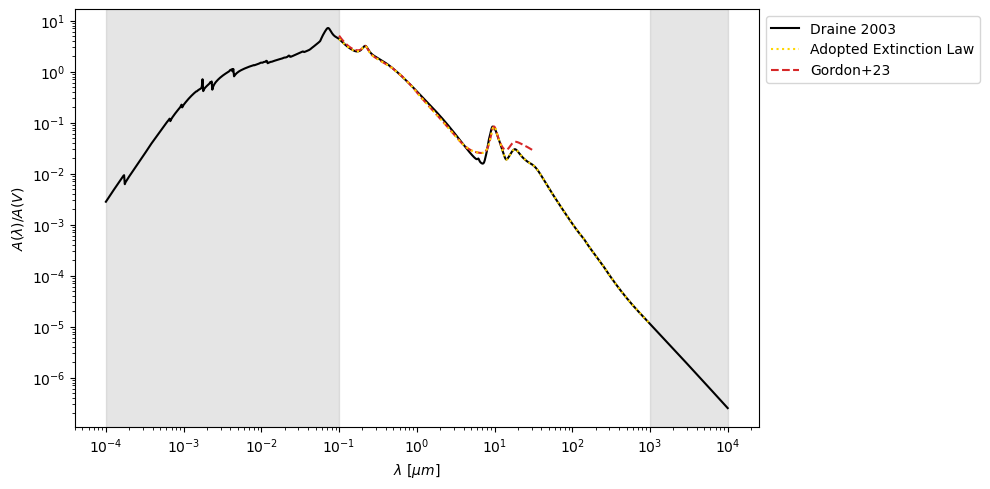

In [24]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(10, 5))
   
indxs, = np.where(np.logical_and(
      1./ lam >= D03.x_range[0],
      1./ lam <= D03.x_range[1]))
ax.plot(lam[indxs], D03("MWRV31")(1./lam[indxs]), label='Draine 2003', color="k")

ax.plot(wl, generate_extinction_law(1/wl), ':', label='Adopted Extinction Law', color="gold", zorder=100)
ax.plot(wl, ext_G23(1/wl), '--', label='Gordon+23', color="tab:red")

# plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
# plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
# plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)



plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e4, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')


ax.set_xscale('log')
ax.set_yscale('log')

# ax.axvline(0.2)
# ax.set_xlim(.08, 1)
# ax.set_ylim(1e-1,10)


ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('/Users/juliaroquette/Work/Plots/my_extinction_Frankenstein_law.png')

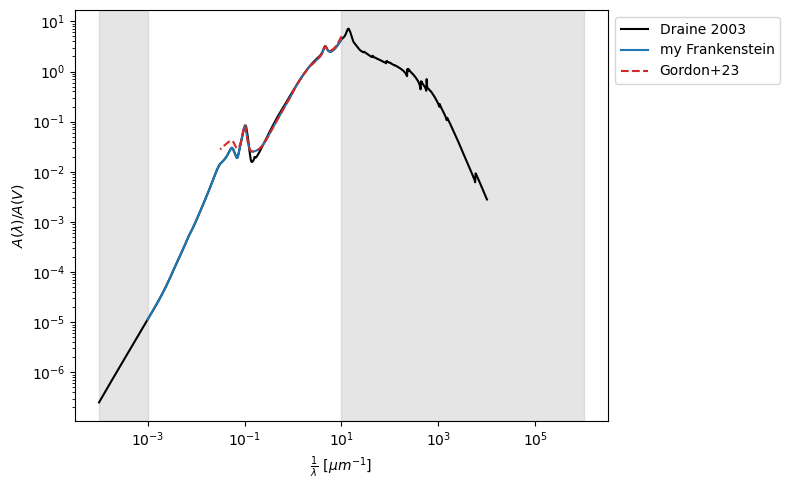

In [25]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(8, 5))
   
indxs, = np.where(np.logical_and(
      1./ lam >= D03.x_range[0],
      1./ lam <= D03.x_range[1]))
ax.plot(1./lam[indxs], D03("MWRV31")(1./lam[indxs]), label='Draine 2003', color="k")

ax.plot(1./wl, generate_extinction_law(1/wl), label='my Frankenstein', color="tab:blue")
ax.plot(1./wl, ext_G23(1/wl), '--', label='Gordon+23', color="tab:red")

# plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
# plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
# plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)



plt.axvspan(xmin=min(1./wl), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=max(1./wl), xmax=1e6, alpha=0.2, color='gray')

ax.set_xlabel(r'$\frac{1}{\lambda}$ [$\mu m^{-1}$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')


ax.set_xscale('log')
ax.set_yscale('log')

# ax.axvline(0.2)
# ax.set_xlim(.08, 1)
# ax.set_ylim(1e-1,10)


ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('/Users/juliaroquette/Work/Plots/my_extinction_Frankenstein_law_1_lambda.png')

# Example of usage

Generate a `.csv` file with the extinction law

In [26]:
import extinction_law

In [27]:
ext = extinction_law.ExtinctionLaw(N=10000)

/Users/juliaroquette/anaconda3/envs/NEMESIS/lib/python3.10/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


In [28]:
ext.save()

In [29]:
x_, y_ = ext.generate_extinction_law()

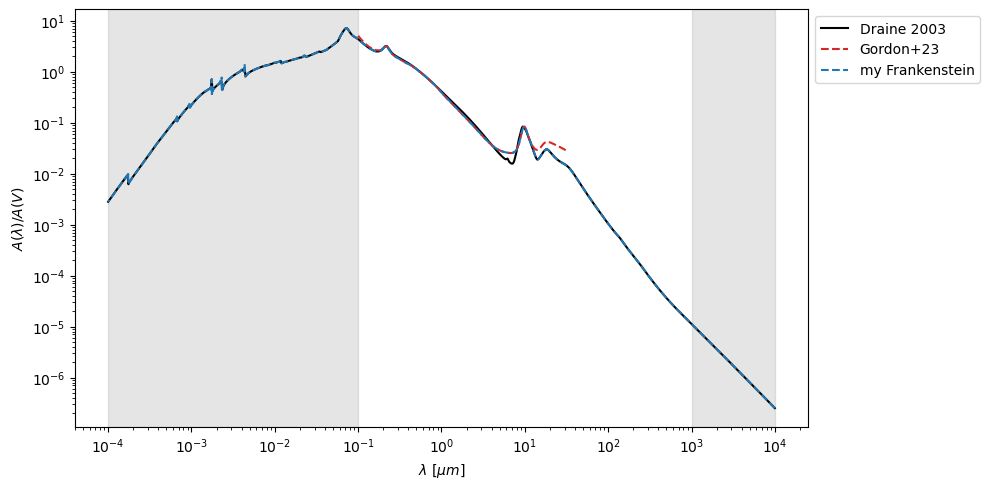

In [30]:
# generate the curves and plot them
lam = np.logspace(-4.0, 5.0, num=1000)

fig, ax = plt.subplots(figsize=(10, 5))
   
indxs, = np.where(np.logical_and(
      1./ lam >= D03.x_range[0],
      1./ lam <= D03.x_range[1]))
ax.plot(lam[indxs], D03("MWRV31")(1./lam[indxs]), label='Draine 2003', color="k")

# ax.plot(wl, generate_extinction_law(1/wl), ':', label='Adopted Extinction Law', color="gold", zorder=100)
ax.plot(wl, ext_G23(1/wl), '--', label='Gordon+23', color="tab:red")
ax.plot(x_, y_, '--', label='my Frankenstein', color="tab:blue")
# plt.plot(wl, cardeli89_Awl_Av(1/wl), '.-', color="tab:green", alpha=0.5, label='Cardeli+89')
# plt.plot(wl, indebetouw2005(wl), ':', color="tab:red",  alpha=0.8)
# plt.plot(wl, mathis90(wl, AV=True), ':,', color='gold', label="Mathis90", alpha=0.8)



plt.axvspan(xmin=wl.min(), xmax=0.0001, alpha=0.2, color='gray')
plt.axvspan(xmin=wl.max(), xmax=1e4, alpha=0.2, color='gray')

ax.set_xlabel('$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')


ax.set_xscale('log')
ax.set_yscale('log')

# ax.axvline(0.2)
# ax.set_xlim(.08, 1)
# ax.set_ylim(1e-1,10)


ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()